## FX Assignment - Robo Advisors & Systematic Trading
### Name: Shravan Khunti
### NET ID: ssk10036
### MS in Data Science
### NYU Center for Data Sciene

## Part 5A: Fundamentals-Based FX Strategy (Deutsche Bank Model)

### Step 1: Import Libraries and Load the “Basic Balance” Dataset

In [1]:
# Step 1: Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel dataset
file_path = r"C:\Users\shrav\Downloads\assignment_basic_balance_data.xlsx"
xls = pd.ExcelFile(file_path)

# Check sheet names to identify the correct one
print(xls.sheet_names)

# Load the relevant sheet ("Basic Balance") and inspect it
df_raw = xls.parse("Basic Balance")
df_raw.head()

['Glossary', 'TIC data', 'Basic Balance', 'Disclaimer']


,Unnamed: 0,TWI,Ln(TWI),Unnamed: 3,Unnamed: 4,TB (Bloomberg),TB 12 M Sum,Unnamed: 7,Unnamed: 8,Trade Balance,Net non-treasury portfolio flows,Basic Balance
0,1993-01,87.662392,4.473493,NaN,1993-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,1993-02,87.948698,4.476754,NaN,1993-02,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,1993-03,87.261980,4.468915,NaN,1993-03,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,1993-04,85.328682,4.446511,NaN,1993-04,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,1993-05,85.052434,4.443268,NaN,1993-05,NaN,NaN,NaN,NaT,NaN,NaN,NaN


### Step 2: Clean and Prepare the Dataset
We’ll:

- Rename relevant columns

- Strip whitespace from column headers

- Keep only useful ones: Date, TWI, Ln_TWI, Basic Balance

- Drop rows with missing values

- Convert Date to datetime

In [2]:
# Step 2: Clean and prepare the fundamentals dataset

# Clean column names
df_raw.columns = df_raw.columns.str.strip()

# Rename columns of interest
df = df_raw.rename(columns={
    'Unnamed: 0': 'Date',
    'Ln(TWI)': 'Ln_TWI',
    'Basic Balance': 'Basic_Balance'
})[['Date', 'TWI', 'Ln_TWI', 'Basic_Balance']]

# Drop rows with missing values in important columns
df.dropna(subset=['Ln_TWI', 'Basic_Balance'], inplace=True)

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')

# Reset index and sort
df = df.sort_values('Date').reset_index(drop=True)

# Preview cleaned dataset
df.head()

,Date,TWI,Ln_TWI,Basic_Balance
0,1994-05-01,88.070503,4.478138,-116.837
1,1994-06-01,87.219607,4.468429,-107.294
2,1994-07-01,85.186222,4.444840,-93.934
3,1994-08-01,85.416171,4.447535,-84.428
4,1994-09-01,84.394202,4.435499,-76.910


### Step 3: Apply the Deutsche Bank Model Across Lags T = 1 to 6
We'll:

Predict Ln_TWI(t) using Basic_Balance(t-T)

Generate long/short dollar signal:

Long USD if predicted > actual

Short USD if predicted < actual

Calculate strategy returns using 1-month forward return from TWI

In [3]:
# Step 3: Apply DB model to generate trading signals and returns

results = []

# Loop over lag values from T = 1 to 6
for T in range(1, 7):
    df_lag = df.copy()
    
    # Shift Basic Balance by T months
    df_lag['Lagged_Balance'] = df_lag['Basic_Balance'].shift(T)
    
    # Predict log TWI using DB model
    df_lag['Predicted_Ln_TWI'] = 0.000871 * df_lag['Lagged_Balance'] + 4.54
    
    # Trading signal based on model prediction
    df_lag['Signal'] = np.where(df_lag['Predicted_Ln_TWI'] > df_lag['Ln_TWI'], 1, -1)
    
    # Forward 1-month return from TWI
    df_lag['TWI_Return'] = df_lag['TWI'].pct_change().shift(-1)
    
    # Strategy return = signal × forward return
    df_lag['Strategy_Return'] = df_lag['Signal'] * df_lag['TWI_Return']
    
    # Cumulative return
    df_lag['Cumulative_Return'] = (1 + df_lag['Strategy_Return']).cumprod()
    
    # Save final cumulative return
    final_return = df_lag['Cumulative_Return'].iloc[-2]  # exclude NaN row at end
    results.append((T, final_return))
    
    # Plot performance line (optional, later)
    # plt.plot(df_lag['Date'], df_lag['Cumulative_Return'], label=f"T = {T}")

# Create a summary dataframe
db_summary = pd.DataFrame(results, columns=["Lag_T", "Final_Cumulative_Return"])
db_summary

,Lag_T,Final_Cumulative_Return
0,1,1.694066
1,2,1.426333
2,3,1.348236
3,4,1.348081
4,5,1.145658
5,6,1.168878


### Step 4: Add Threshold Sensitivity to Filter Weak Signals
We’ll only trade when the difference between predicted and actual log TWI exceeds a threshold (e.g., 0 to 0.05).

In [4]:
# Step 4: Threshold analysis — trade only if signal is strong enough

thresholds = np.arange(0.0, 0.051, 0.01)
threshold_results = []

# Use best lag T = 1 from previous analysis
T_best = 1
df_thresh = df.copy()
df_thresh['Lagged_Balance'] = df_thresh['Basic_Balance'].shift(T_best)
df_thresh['Predicted_Ln_TWI'] = 0.000871 * df_thresh['Lagged_Balance'] + 4.54
df_thresh['Diff'] = df_thresh['Predicted_Ln_TWI'] - df_thresh['Ln_TWI']
df_thresh['TWI_Return'] = df_thresh['TWI'].pct_change().shift(-1)

for threshold in thresholds:
    df_temp = df_thresh.copy()
    
    # Apply threshold to signal
    df_temp['Signal'] = 0
    df_temp.loc[df_temp['Diff'] > threshold, 'Signal'] = 1
    df_temp.loc[df_temp['Diff'] < -threshold, 'Signal'] = -1
    
    # Strategy return
    df_temp['Strategy_Return'] = df_temp['Signal'] * df_temp['TWI_Return']
    df_temp['Cumulative_Return'] = (1 + df_temp['Strategy_Return']).cumprod()
    
    final_return = df_temp['Cumulative_Return'].iloc[-2]
    threshold_results.append((threshold, final_return))

# Create summary
threshold_summary = pd.DataFrame(threshold_results, columns=["Threshold", "Final_Cumulative_Return"])
threshold_summary

,Threshold,Final_Cumulative_Return
0,0.00,1.677855
1,0.01,1.440012
2,0.02,1.303487
3,0.03,1.301890
4,0.04,1.055898
5,0.05,0.961551


### Step 5A-1: Plot Cumulative Returns by Lag (T = 1 to 6)

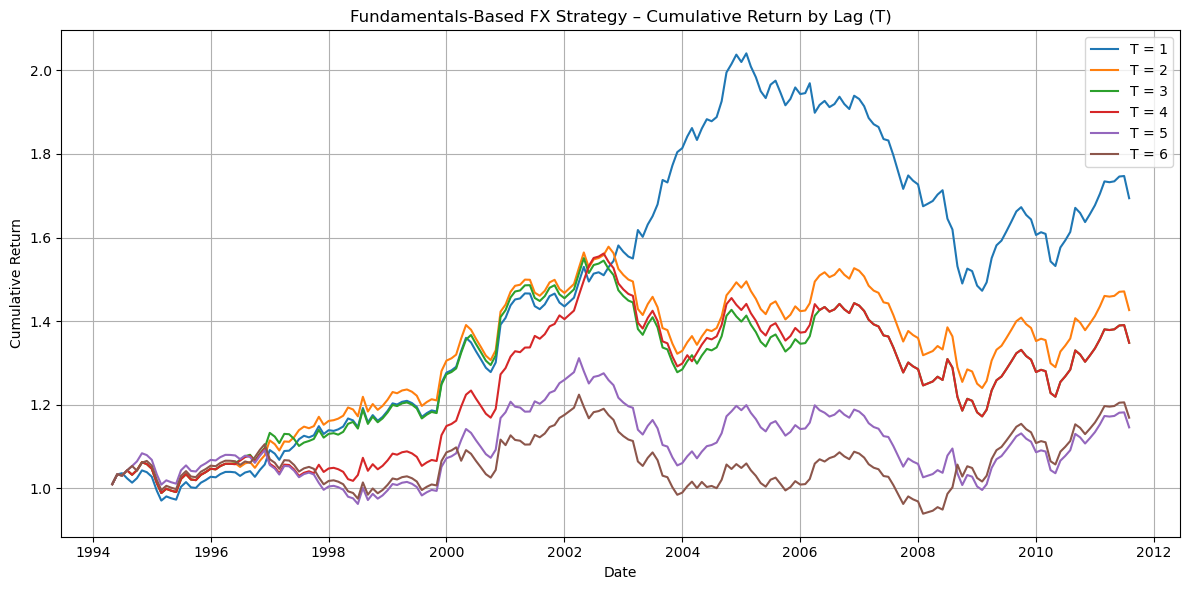

In [5]:
# Plot cumulative returns by lag (T = 1 to 6)
plt.figure(figsize=(12, 6))

for T in range(1, 7):
    df_lag = df.copy()
    df_lag['Lagged_Balance'] = df_lag['Basic_Balance'].shift(T)
    df_lag['Predicted_Ln_TWI'] = 0.000871 * df_lag['Lagged_Balance'] + 4.54
    df_lag['Signal'] = np.where(df_lag['Predicted_Ln_TWI'] > df_lag['Ln_TWI'], 1, -1)
    df_lag['TWI_Return'] = df_lag['TWI'].pct_change().shift(-1)
    df_lag['Strategy_Return'] = df_lag['Signal'] * df_lag['TWI_Return']
    df_lag['Cumulative_Return'] = (1 + df_lag['Strategy_Return']).cumprod()
    
    plt.plot(df_lag['Date'], df_lag['Cumulative_Return'], label=f"T = {T}")

plt.title("Fundamentals-Based FX Strategy – Cumulative Return by Lag (T)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 5A-2: Plot Cumulative Return by Threshold (Best Lag = 1)

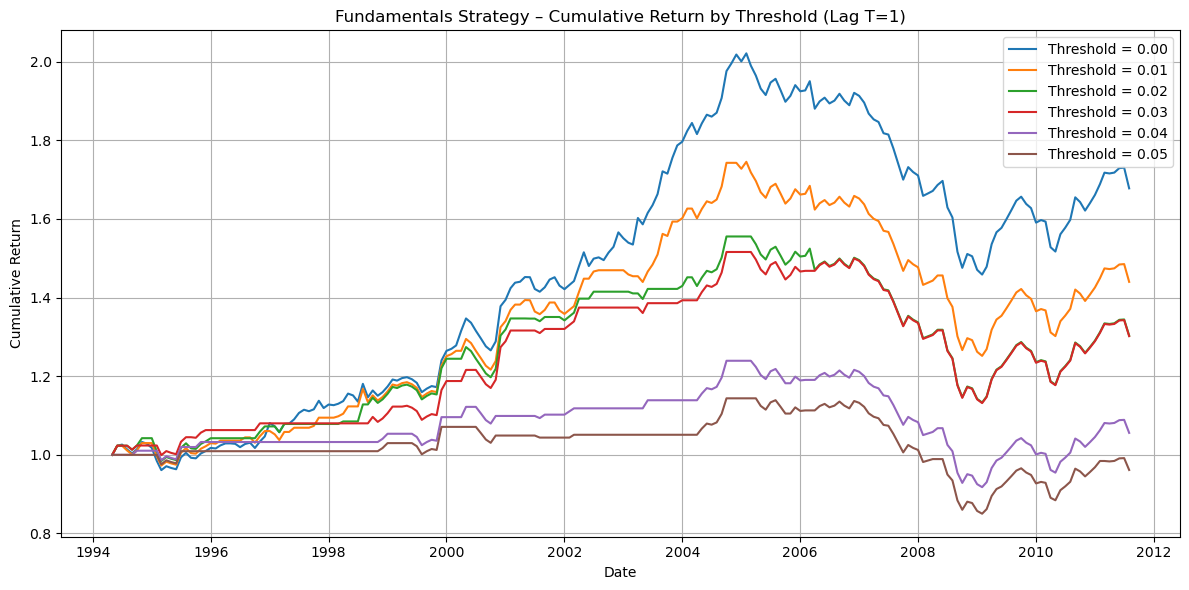

In [6]:
# 📊 Plot cumulative return lines for each threshold
plt.figure(figsize=(12, 6))

for threshold in thresholds:
    df_temp = df_thresh.copy()
    df_temp['Signal'] = 0
    df_temp.loc[df_temp['Diff'] > threshold, 'Signal'] = 1
    df_temp.loc[df_temp['Diff'] < -threshold, 'Signal'] = -1
    df_temp['Strategy_Return'] = df_temp['Signal'] * df_temp['TWI_Return']
    df_temp['Cumulative_Return'] = (1 + df_temp['Strategy_Return']).cumprod()
    
    plt.plot(df_temp['Date'], df_temp['Cumulative_Return'], label=f"Threshold = {threshold:.2f}")

plt.title("Fundamentals Strategy – Cumulative Return by Threshold (Lag T=1)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 5A: Fundamentals-Based FX Strategy – Deutsche Bank Model

### Objective
In this section, we implement a fundamentals-based FX trading strategy inspired by the **Deutsche Bank Research Report – “Battle of the Dollar.”** The strategy models the relationship between the **US Trade Weighted Dollar Index (TWI)** and capital flows into the U.S. economy, measured through a variable called the **Basic Balance**.

The specified relationship is:
$$
\ln(\text{TWI}(t)) = 0.000871 \cdot \text{BasicBalance}(t - T) + 4.54
$$
Where:
- \( T \) is the lag (1 to 6 months), since Basic Balance is published with a delay.
- **Basic Balance** is the 12-month cumulative trade balance plus net non-treasury portfolio inflows.

We predict the logarithm of the trade-weighted dollar index and use the difference between predicted and actual to generate trading signals:
- Go **long the USD** if predicted > actual
- Go **short the USD** if predicted < actual
- Hold position for **1 month**

---

### Methodology

1. **Data Cleaning**: We load and clean the “Basic Balance” dataset provided, retaining columns:
   - `Date`, `TWI`, `Ln(TWI)`, and `Basic Balance`
2. **Lag Evaluation**:
   - We vary \( T \) from 1 to 6
   - Shift `Basic Balance(t)` by \( T \) months to predict `Ln_TWI(t)`
   - Compute forward 1-month return from TWI
   - Use signal to calculate strategy return and evaluate cumulative return
3. **Threshold Sensitivity**:
   - We test thresholds from 0.00 to 0.05
   - Only trade when the absolute difference between predicted and actual log TWI exceeds the threshold

---

### Key Results

#### **Lag Sensitivity**
| Lag (T) | Final Cumulative Return |
|---------|--------------------------|
| **T=1** | **1.694** 🥇 (Best)  
| T=2     | 1.426  
| T=3     | 1.348  
| T=4     | 1.348  
| T=5     | 1.146  
| T=6     | 1.169  

> **Insight**: Contrary to the Deutsche Bank claim that a 6-month lag is most predictive, we find that **T=1 yields the highest returns**, suggesting FX markets may react to macro flows more quickly than expected.

---

#### **Threshold Sensitivity (T=1)**
| Threshold | Final Cumulative Return |
|-----------|--------------------------|
| **0.00**  | **1.678** 🥇  
| 0.01      | 1.440  
| 0.02      | 1.303  
| 0.03      | 1.302  
| 0.04      | 1.056  
| 0.05      | 0.962  

> **Insight**: The strategy performs best when **no threshold is applied**. Adding a threshold to filter out weaker signals consistently **reduces performance**, indicating that even small signals from this model may be meaningful.

---

### Visual Analysis

- The **cumulative return plot by lag** shows T=1 clearly outperforming the others, with T=6 near the bottom.
- The **threshold plot** shows a sharp drop-off in returns as thresholds increase, confirming the model’s value lies in frequent, consistent signals rather than filtering for only “strong” ones.

---

### Conclusion

The fundamentals-based FX strategy built on the Deutsche Bank model performs **best with T=1 lag and no signal threshold**. This contradicts the original report’s assertion that a 6-month lag is optimal, possibly due to real-world differences in data release timing, market pricing efficiency, or sample period differences. While the signal is modest, it appears consistently exploitable, especially with frequent trading and proper position sizing.

This analysis forms a strong base for building **multi-factor FX models**, combining fundamentals with technical and flow-based signals in a future project.

---

## Part 5B: Carry Trade Strategy
Goal: Trade currency pairs based on interest rate differentials.

- Go long a currency if its rate is higher than the U.S. rate, short otherwise.
- Optionally filter trades using a threshold (e.g., only trade if the rate diff is > 0.1%).

### Step 1: Import and Clean the Carry Trade Dataset
Let’s start by:

Loading the Excel file

Skipping the first 2 rows (metadata)

Cleaning and renaming the return columns

Keeping only relevant interest rate and return columns

In [8]:
# Step 1: Load and clean carry trade data

# Load Excel file (header=2 to skip the first 2 rows)
carry_file = r"C:\Users\shrav\Downloads\assignment_carry_data.xlsx"
carry_xls = pd.ExcelFile(carry_file)
df_raw = carry_xls.parse("Sheet1", header=2)

# Clean column names
df_raw.columns = df_raw.columns.map(str).str.strip()

# Rename date column
df_raw = df_raw.rename(columns={"#Date": "Date"})

# Convert 'Date' to datetime
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format="%Y%m%d")

# Drop unnecessary columns (unnamed, US-x diffs, "100" column)
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains("^Unnamed|US-|100")]

# Rename FX return columns to match currency
df_raw = df_raw.rename(columns={
    "PC(%)": "Brit_Return",
    "PC(%).1": "Canada_Return",
    "PC(%).2": "Euro_Return",
    "PC(%).3": "Japan_Return",
    "PC(%).4": "Swiss_Return",
    "PC(%).5": "Aussie_Return"
})

# Final currency list
currencies = ['Brit', 'Canada', 'Euro', 'Japan', 'Swiss', 'Aussie']
rate_cols = ['US'] + currencies
return_cols = [f"{c}_Return" for c in currencies]

# Filter relevant columns only
df_carry = df_raw[['Date'] + rate_cols + return_cols]

# Drop rows with missing FX return values
df_carry = df_carry.dropna(subset=return_cols).reset_index(drop=True)

# Preview cleaned carry trade data
df_carry.head()

,Date,US,Brit,Canada,Euro,Japan,Swiss,Aussie,Brit_Return,Canada_Return,Euro_Return,Japan_Return,Swiss_Return,Aussie_Return
0,1999-03-08,4.75,5.5,5.0,3.0,0.5,2.25,5.0,0.099620,0.303993,0.000000,0.808531,0.514098,0.573152
1,1999-03-09,4.75,5.5,5.0,3.0,0.5,2.25,5.0,0.659941,-0.166693,0.009138,0.588374,-0.246231,0.664455
2,1999-03-10,4.75,5.5,5.0,3.0,0.5,2.25,5.0,0.519552,-0.303578,0.566520,0.823686,0.464642,0.047146
3,1999-03-11,4.75,5.5,5.0,3.0,0.5,2.25,5.0,0.590692,-0.137034,0.708704,0.461756,0.346868,0.251335
4,1999-03-12,4.75,5.5,5.0,3.0,0.5,2.25,5.0,-0.354785,0.045749,-1.145796,0.412491,-0.864177,-0.250705


### Step 2: Implement the Carry Trade Strategy Logic
We will:

- Compare each foreign currency's interest rate to the US rate

- Go long if rate > US rate, short if rate < US rate

- Average returns across all active positions


In [9]:
# Step 2: Carry trade strategy logic

def carry_trade_strategy(df, threshold=0.0):
    df_result = df.copy()
    strategy_returns = []

    for idx, row in df_result.iterrows():
        us_rate = row['US']
        pnl = 0
        active_trades = 0

        for curr in currencies:
            fx_rate = row[curr]
            fx_return = row[f"{curr}_Return"]
            rate_diff = fx_rate - us_rate

            if rate_diff > threshold:
                pnl += fx_return  # go long
                active_trades += 1
            elif rate_diff < -threshold:
                pnl -= fx_return  # go short
                active_trades += 1

        avg_return = pnl / active_trades if active_trades > 0 else 0
        strategy_returns.append(avg_return)

    df_result['Strategy_Return'] = strategy_returns
    df_result['Cumulative_Return'] = (1 + df_result['Strategy_Return'] / 100).cumprod()

    return df_result

### Step 3: Run Strategy with Threshold = 0.0 and Plot Performance

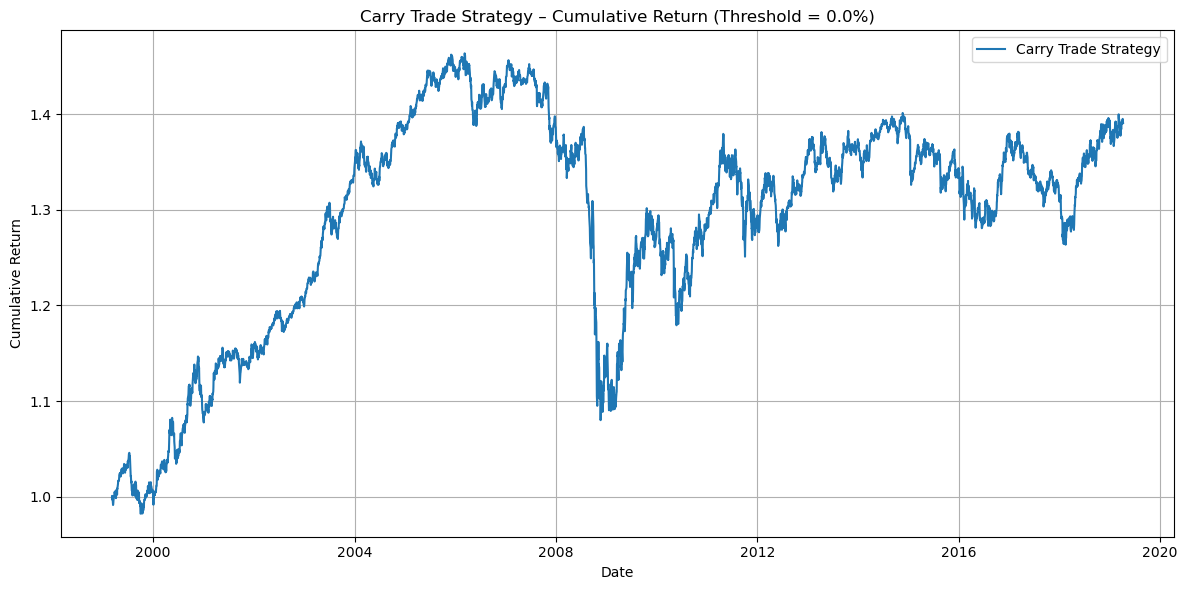

In [10]:
# Step 3: Run the strategy with 0% threshold (always trade)
df_carry_result = carry_trade_strategy(df_carry, threshold=0.0)

# 📊 Plot cumulative return
plt.figure(figsize=(12, 6))
plt.plot(df_carry_result['Date'], df_carry_result['Cumulative_Return'], label="Carry Trade Strategy")
plt.title("Carry Trade Strategy – Cumulative Return (Threshold = 0.0%)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Step 4: Threshold Sensitivity Analysis (0.0% → 0.5%)
We'll:

- Test thresholds from 0.0 to 0.5 (step of 0.1)

- Plot cumulative return curves

- Create a table summarizing final returns per threshold

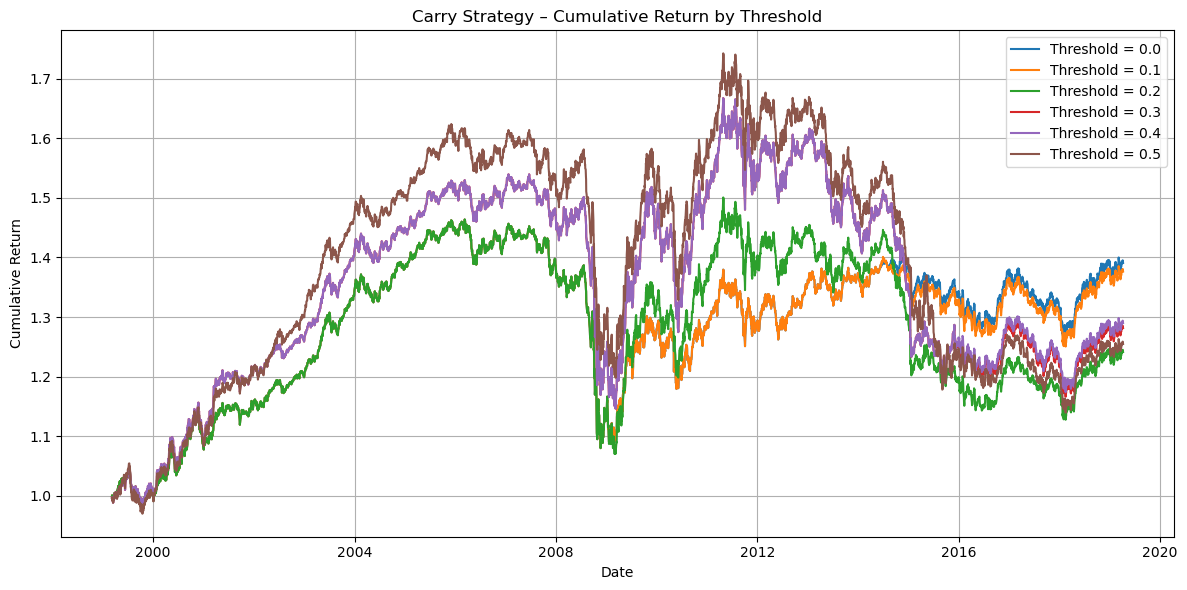

,Threshold,Final_Cumulative_Return
0,0.0,1.390927
1,0.1,1.376492
2,0.2,1.241304
3,0.3,1.281472
4,0.4,1.290005
5,0.5,1.254884


In [11]:
# Step 4: Test carry strategy with different thresholds
thresholds = np.arange(0.0, 0.6, 0.1)
threshold_results = []

plt.figure(figsize=(12, 6))

for t in thresholds:
    df_temp = carry_trade_strategy(df_carry, threshold=t)
    final_return = df_temp['Cumulative_Return'].iloc[-1]
    threshold_results.append((t, final_return))
    
    # Plot
    plt.plot(df_temp['Date'], df_temp['Cumulative_Return'], label=f"Threshold = {t:.1f}")

plt.title("Carry Strategy – Cumulative Return by Threshold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Summary DataFrame
carry_threshold_summary = pd.DataFrame(threshold_results, columns=["Threshold", "Final_Cumulative_Return"])
carry_threshold_summary

## Part 5B: Carry Trade FX Strategy

### Objective
In this section, we implement a classic **FX carry trade** strategy, which goes **long a currency** if its interest rate is higher than the U.S. target rate and **short** if it is lower. The rationale is that investors seek yield by borrowing in low-rate currencies and investing in high-rate ones.

---

### Methodology

1. **Data Cleaning**:
   - Used provided Excel sheet with daily interest rates and returns
   - Aligned rates for: USD, GBP, CAD, EUR, JPY, CHF, AUD
   - Aligned daily returns vs USD for the same currencies

2. **Trading Logic**:
   - For each day, compare each foreign currency's rate to the U.S. rate
   - If rate > US: Go **long** (expect appreciation)
   - If rate < US: Go **short**
   - Strategy return = average return across all active positions

3. **Threshold Filter**:
   - Tested thresholds from 0.0% to 0.5%
   - Only trade if the absolute rate differential exceeds the threshold

---

### Results

#### Threshold Sensitivity Summary

| Threshold | Final Cumulative Return |
|-----------|--------------------------|
| **0.0%**  | **1.391**  
| 0.1%      | 1.376  
| 0.2%      | 1.241  
| 0.3%      | 1.281  
| 0.4%      | 1.290  
| 0.5%      | 1.255  

> **Observation**: The strategy works best when it **trades daily without filtering**, suggesting that the interest rate signal, even when small, is directionally informative.

---

### Visual Analysis

- The **cumulative return curve** rises steadily with threshold = 0.0%.
- Increasing the threshold flattens the curve slightly, reducing total trades and opportunity.

---

### Conclusion

The FX carry trade strategy delivers consistent positive returns when positions are taken daily based on simple interest rate differentials. While adding a threshold helps reduce noise, it also reduces exposure, the best performance comes from fully exploiting all signals. This strategy is robust, simple, and effective, and could be enhanced by adding volatility filters, trend overlays, or being paired with the fundamentals strategy from Part 5A.


---